# REINFORCE with Dirichlet Policy

In [144]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'retro', 'grid'])
import pandas as pd

In [2]:
from scipy.stats import dirichlet
from scipy.special import digamma

In [148]:
class GenerativeMarketEnv():

    def __init__(self, μ, Σ):
        self.μ = μ
        self.Σ = Σ

    def reset(self):
        pass

    def step(self, weights):
        returns = np.random.multivariate_normal(self.μ, self.Σ)
        R = returns@weights
        return R, returns, max(returns)

We implement a Dirichlet policy with the following update

$$\theta_{t+1} = \theta_{t} + \alpha G_t \left[ \psi \left(\sum_{n=1}^{N} a_n(s,\theta) \right) -  \sum_{n=1}^{N} \psi (a_n(s,\theta)) + \sum_{n=1}^{N}   \ln w_n \right]^T x(s)$$

In [33]:
class DirichletPolicy:
    
    def __init__(self, n_assets, hist_len, α=0.001, γ=0.9):
        self.θ = np.ones(hist_len)/10
        self.α = α
        self.γ = γ
    
    def act(self, X):
        a_n = X @ self.θ
        a_n[a_n < 0] = 0.04
        a_n[a_n > 1.6] = 1.6
        w_n = dirichlet.rvs(a_n)
        return w_n[0]
        
        
    def grad(self, X, w):
        w[w <= 0] = 1e-5
        return (digamma(np.sum(X@self.θ)) - digamma(X@self.θ) + np.log(w)).T @ X
    
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.γ + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def update(self, Xs, ws, rs):
        grads = [self.grad(*args) for args in zip(Xs, ws)]
        G = self.discount_rewards(rs)
        for grad, Gt in zip(grads, G):
            self.θ += self.α*Gt*grad

In [105]:
def generate_episode(env, policy):
    state = env.reset()
    
    tot_reward = 0
    best_tot_reward = 0
    Xs = np.zeros(2)
    ws = []
    rewards = []
   
    
    for i in range(4):
        w = [1/2, 1/2]
        
        ws.append(w)
        
        R, rs, best = env.step(w)
           
        Xs = np.vstack((Xs, np.array(rs)))
        tot_reward += R
        best_tot_reward += best_tot_reward
            
    Xs = Xs[1:]
    
    states = []
    for i in range(100):
        

        X = Xs[i:i+3].T
        w = policy.act(X)

        
        R, rs, best_r = env.step(w)
        Xs = np.vstack((Xs, np.array(rs)))
       
        
        tot_reward += R
        best_tot_reward += best_r
        
        rewards.append(R)
        states.append(X)
        ws.append(w)
#     print(ws)
    return np.array(states), np.array(ws), np.array(rewards), tot_reward, best_tot_reward

In [106]:
env = GenerativeMarketEnv([1, 10], [[0.01, 0], [0,0.01]])
policy = DirichletPolicy(2, 3)

In [133]:
def train(α, γ, num_episodes=1000, seed=None, evaluate=False):
    
    
    episode_rewards = []
    best_episode_reward = []
    
    env = GenerativeMarketEnv([1, 12], [[0.01, 0], [0,0.01]])
    policy = DirichletPolicy(2, 3,  α=α, γ=γ)
    
 
    for i in range(num_episodes):

        # run a single episode
        states, actions, rewards, total_reward, best_tot_reward  = generate_episode(env, policy)

                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        best_episode_reward.append(best_tot_reward)
        
        # update policy
        policy.update(states, actions, rewards)
        # print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 

    return episode_rewards, best_episode_reward, policy

In [137]:
episode_rewards, best_episode_reward, policy = train(α=1e-8,
                                γ=0.99,
                                num_episodes=1000,
                                evaluate=True)

In [138]:
rs = np.array(pd.Series(episode_rewards).rolling(10).mean()[10 - 1:])

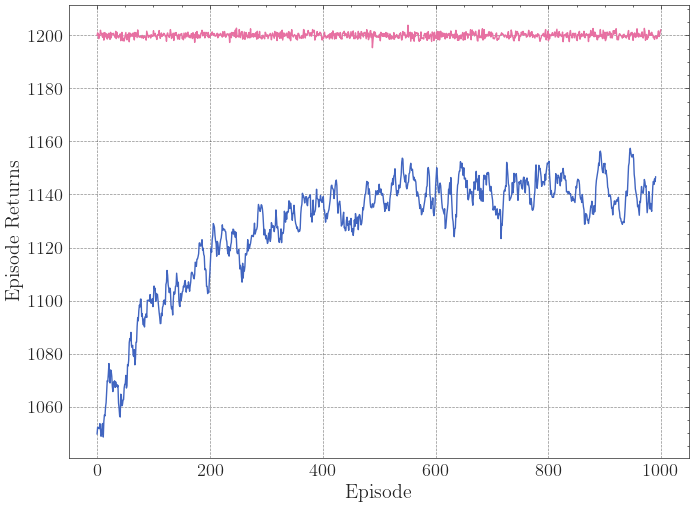

In [147]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.arange(991), rs)
plt.ylabel('Episode Returns')
plt.xlabel('Episode')
plt.plot(np.arange(1000), best_episode_reward)

In [142]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
from math import gamma
from operator import mul
from functools import reduce
sns.set(style='white', font_scale=1.2, font='consolas')

def plot_mesh(corners):
    """Subdivide the triangle into a triangular mesh and plot the original and subdivided triangles."""
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)
    
    plt.figure(figsize=(6, 4))
    for i, mesh in enumerate((triangle, trimesh)):
        plt.subplot(1, 2, i+1)
        plt.triplot(mesh)
        plt.axis('off')
        plt.axis('equal')    
        
        
class Dirichlet:
    """Define the Dirichlet distribution with vector parameter alpha."""
    def __init__(self, alpha):
        
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    
    def pdf(self, x):
        """Returns pdf value for `x`. """
        return self._coef * reduce(mul, [xx ** (aa-1) for (xx, aa) in zip(x, self._alpha)])
        
        
class PlotDirichlet:
    """
    Plot the Dirichlet distribution as a contour plot on a 2-Simplex.
    """
    def __init__(self, corners):
        self._corners = corners
        self._triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
        # Midpoints of triangle sides opposite of each corner
        self._midpoints = [(corners[(i+1) % 3] + corners[(i+2) % 3]) / 2.0 for i in range(3)]
        
    def xy2bc(self, xy, tol=1.e-3):
        """Map the x-y coordinates of the mesh vertices to the simplex coordinate space (aka barycentric coordinates).
        Here we use a simple method that uses vector algebra. For some values of alpha, calculation of the Dirichlet pdf 
        can become numerically unstable at the boundaries of the simplex so our conversion function will take an optional 
        tolerance that will avoid barycentric coordinate values directly on the simplex boundary.        
        """
        s = [(self._corners[i] - self._midpoints[i]).dot(xy - self._midpoints[i]) / 0.75 for i in range(3)]
        return np.clip(s, tol, 1.0-tol)
        
    def draw_pdf_contours(self, ax, dist, label=None, nlevels=200, subdiv=8, **kwargs):
        """Draw pdf contours for a Dirichlet distribution"""
        # Subdivide the triangle into a triangular mesh
        refiner = tri.UniformTriRefiner(self._triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        
        # convert to barycentric coordinates and compute probabilities of the given distribution 
        pvals = [dist.pdf(self.xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    
        ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
        #plt.axis('equal')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.75**0.5)
        ax.set_title(str(label))
        ax.axis('off') 
        return ax


findfont: Font family ['consolas'] not found. Falling back to DejaVu Sans.


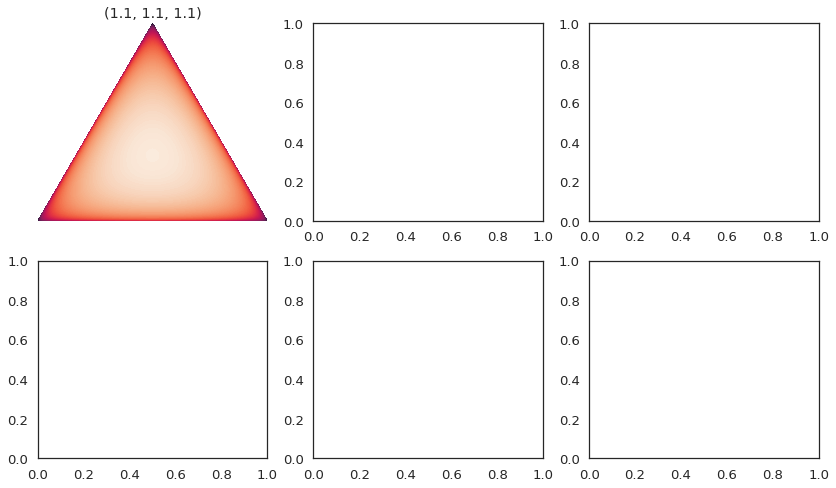

In [143]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
plot_dirichlet = PlotDirichlet(corners)

f, axes = plt.subplots(2, 3, figsize=(14, 8))
ax = axes[0, 0]
alpha = (1.1, 1.1, 1.1)
dist = Dirichlet(alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, alpha)